In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, random_clifford, Pauli, Operator, partial_trace, entropy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from quantum_simulation_recipe.spin import Nearest_Neighbour_1d
from quantum_simulation_recipe.trotter import *
from quantum_simulation_recipe.bounds import norm, tight_bound, commutator
from quantum_simulation_recipe.plot_config import *
from time import sleep
from tqdm import tqdm

def StateError(state,ErrorU):
    st=ErrorU @ state
    error=np.real(st.conj().T @ st)
    return np.sqrt(error)

States_of_different_magics=np.load("./data/differentstates.npy")
Magics=np.load("./data/differentmagics_right.npy")

In [2]:
# Model: 1D Heisenberg model
n=10
J,h=1,0.2
t=10
r=100 
delta_t=t/r
order=1
hnn=Nearest_Neighbour_1d(n=n,Jx=J,Jy=J,Jz=J,hx=h,hy=0,hz=0,pbc=True)
h_list=hnn.ham_xyz
approx_U=pf(h_list,t=delta_t,r=1,order=1)
exact_U=expH(hnn.ham,delta_t)
Error_U=exact_U-approx_U

#Distribution of errors for different magics
SampleScale=10000
Errors=np.load("./OtherHamiltonians/5qubitsHeisenbergGCdistribution.npy").tolist()
if(False):#Generate data
    Update_errors=[]
    j=0
    for i,st in enumerate(States_of_different_magics):
        if i in [0,1,2,4,8]: 
            pbar=tqdm(total=SampleScale)
            step=0
            state=Statevector(st)
            sample=Errors[j]
            while step < SampleScale:
                state=state.evolve(random_clifford(n))
                error=StateError(state.data,Error_U)
                sample.append(error)
                pbar.update(1)
                step+=1  
            pbar.close()
            Update_errors.append(sample)
            j+=1
    print(Update_errors)
    np.save("./OtherHamiltonians/5qubitsHeisenbergGCdistribution.npy",Update_errors)

R-squared for kurtosis fit: 0.9852428079167997


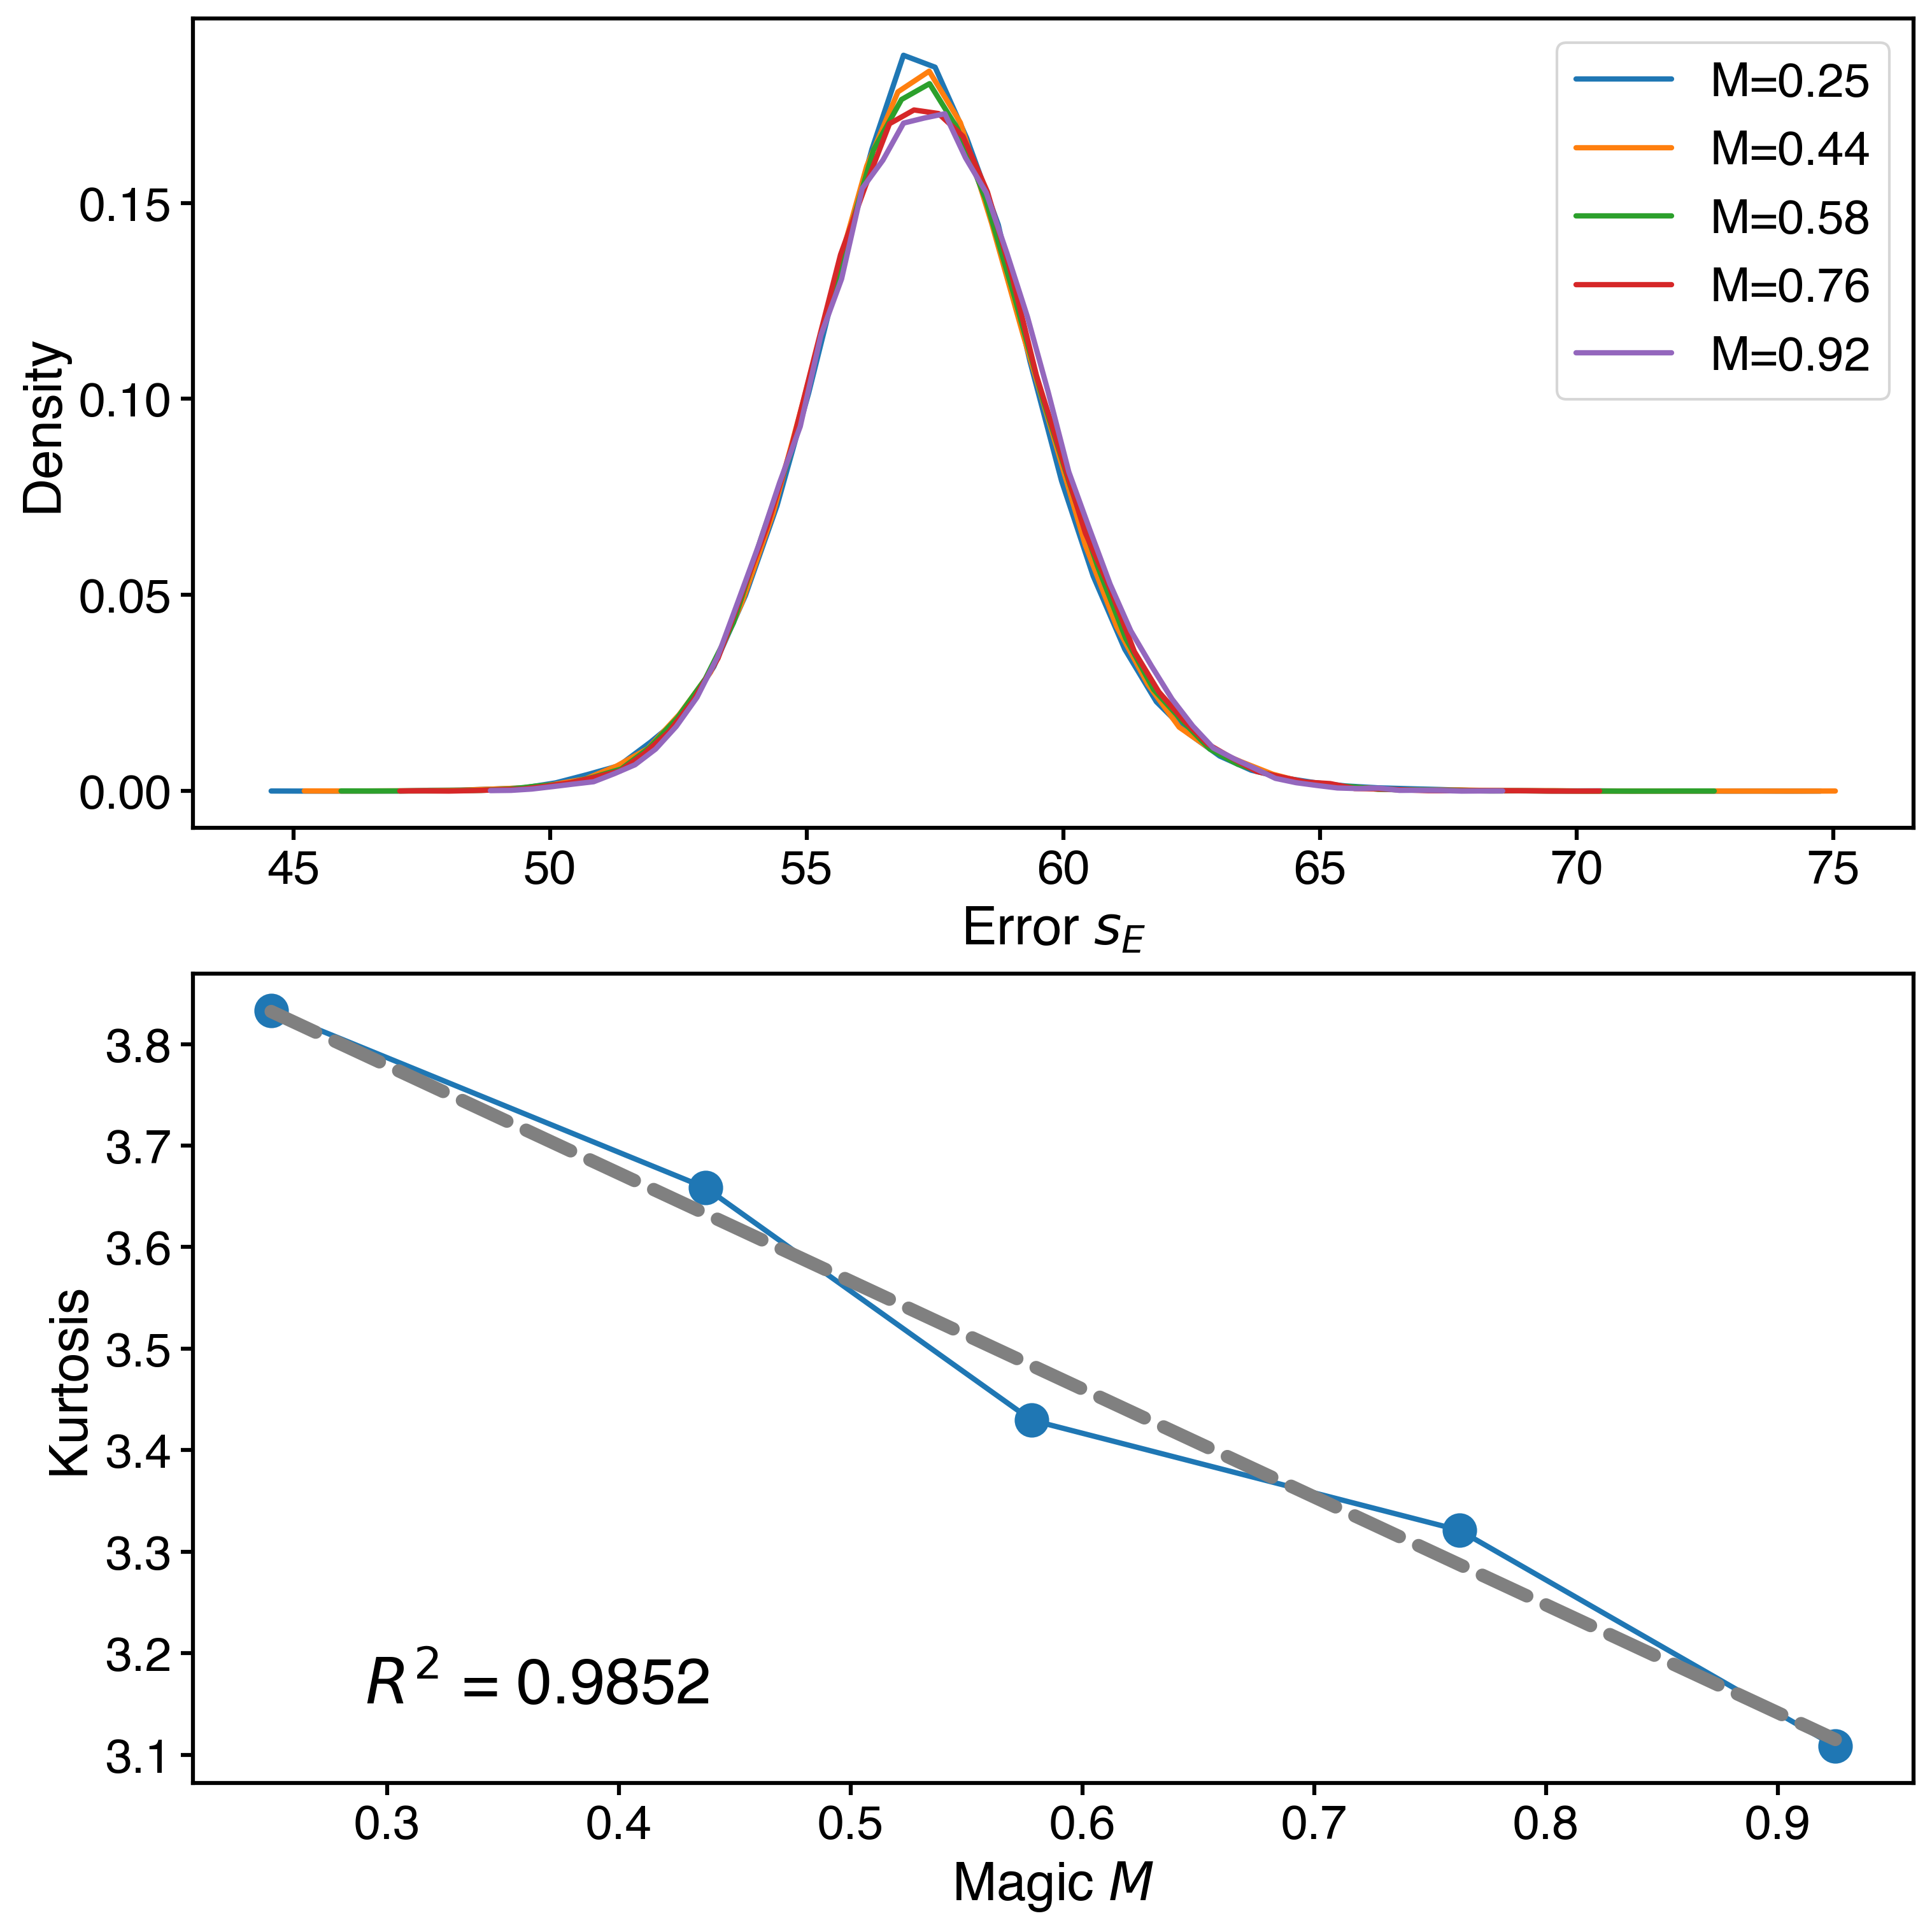

In [3]:
fig, (ax_up, ax_down) = plt.subplots(2,1, figsize=(10,10), layout='constrained')
label_size=20
ax_up.set_xlabel(r"Error $s_E$", fontsize=label_size)
ax_up.set_ylabel(r"Density", fontsize=label_size)
ax_down.set_xlabel(r"Magic $M$", fontsize=label_size)
ax_down.set_ylabel(r"Kurtosis", fontsize=label_size)
ax_up.tick_params(axis='both', which='major', labelsize=label_size-2)
ax_down.tick_params(axis='both', which='major', labelsize=label_size-2)
kurtosis=[]
magics_to_plot=[]
j=0
for i in range(len(Magics)):
    if i in [0,1,2,4,8]:
        S_E=np.power(Errors[j],2)/np.power(delta_t,2*order+2)
        hists, bins = np.histogram(S_E, 50, density=True)
        ax_up.plot(bins[:-1], np.power(hists, 1),label=f'M={Magics[i]:.2f}')
        kurtosis.append(np.mean((S_E-np.mean(S_E))**4)/np.var(S_E)**2)
        magics_to_plot.append(Magics[i])
        j+=1
ax_down.plot(magics_to_plot, kurtosis, marker='o')
#Linear fit
z1 = np.polyfit(magics_to_plot, kurtosis, 1)
p1 = np.poly1d(z1)
R_squared = np.corrcoef(kurtosis, p1(magics_to_plot))[0,1]**2
print(f"R-squared for kurtosis fit: {R_squared}")
moments_pre = p1(magics_to_plot)
ax_down.plot(magics_to_plot, moments_pre, "--", color='gray', linewidth=5, label='Linear fit')
plt.text(0.2, 0.12, rf"$R^2$ = {R_squared:.4f}", ha='center', va='center', transform=ax_down.transAxes, fontsize=24)
ax_up.legend()
plt.show()

In [4]:
#Distribution of errors for different entanglement
def random_local(state):
    n=state.num_qubits
    for i in range(n):
        state=state.evolve(random_clifford(1),[i])
    return state
States_of_typical_entanglement=np.load("./vardata/entstates.npy")
States_of_atypical_entanglement=np.load("./vardata/antientstates.npy")
Tyentropies=np.load("vardata/part4typical.npy")
Atyentropies=np.load("vardata/part4atypical.npy")

SampleScale=1000
TypicalErrors=np.load("./OtherHamiltonians/HeisenbergLUtypical.npy").tolist()
AtypicalErrors=np.load("./OtherHamiltonians/HeisenbergLUatypical.npy").tolist()
if(False):#Generate data
    Typical_errors_update=[]
    Atypical_errors_update=[]
    pbar=tqdm(total=len(States_of_typical_entanglement))
    for i,st in enumerate(States_of_typical_entanglement):
        step=0
        state=Statevector(st)
        sample=TypicalErrors[i]
        while step < SampleScale:
            state=random_local(state)
            error=StateError(state.data,Error_U)
            sample.append(error)
            step+=1  
        Typical_errors_update.append(sample)
        pbar.update(1)
    pbar.close()
    print(Typical_errors_update)
    np.save("./OtherHamiltonians/HeisenbergLUtypical.npy",Typical_errors_update)

    pbar=tqdm(total=len(States_of_atypical_entanglement))
    for i,st in enumerate(States_of_atypical_entanglement):
        step=0
        state=Statevector(st)
        sample=AtypicalErrors[i]
        while step < SampleScale:
            state=random_local(state)
            error=StateError(state.data,Error_U)
            sample.append(error)
            step+=1  
        Atypical_errors_update.append(sample)
        pbar.update(1)
    pbar.close()
    print(Atypical_errors_update)
    np.save("./OtherHamiltonians/HeisenbergLUatypical.npy",Atypical_errors_update)
Atyvariances=[]
Tyvariances=[]
i=0
while i < len(TypicalErrors):
    Tyvariances.append(np.var(np.power(TypicalErrors[i],2)/np.power(delta_t,2*order+2)))
    Atyvariances.append(np.var(np.power(AtypicalErrors[i],2)/np.power(delta_t,2*order+2)))
    i+=1

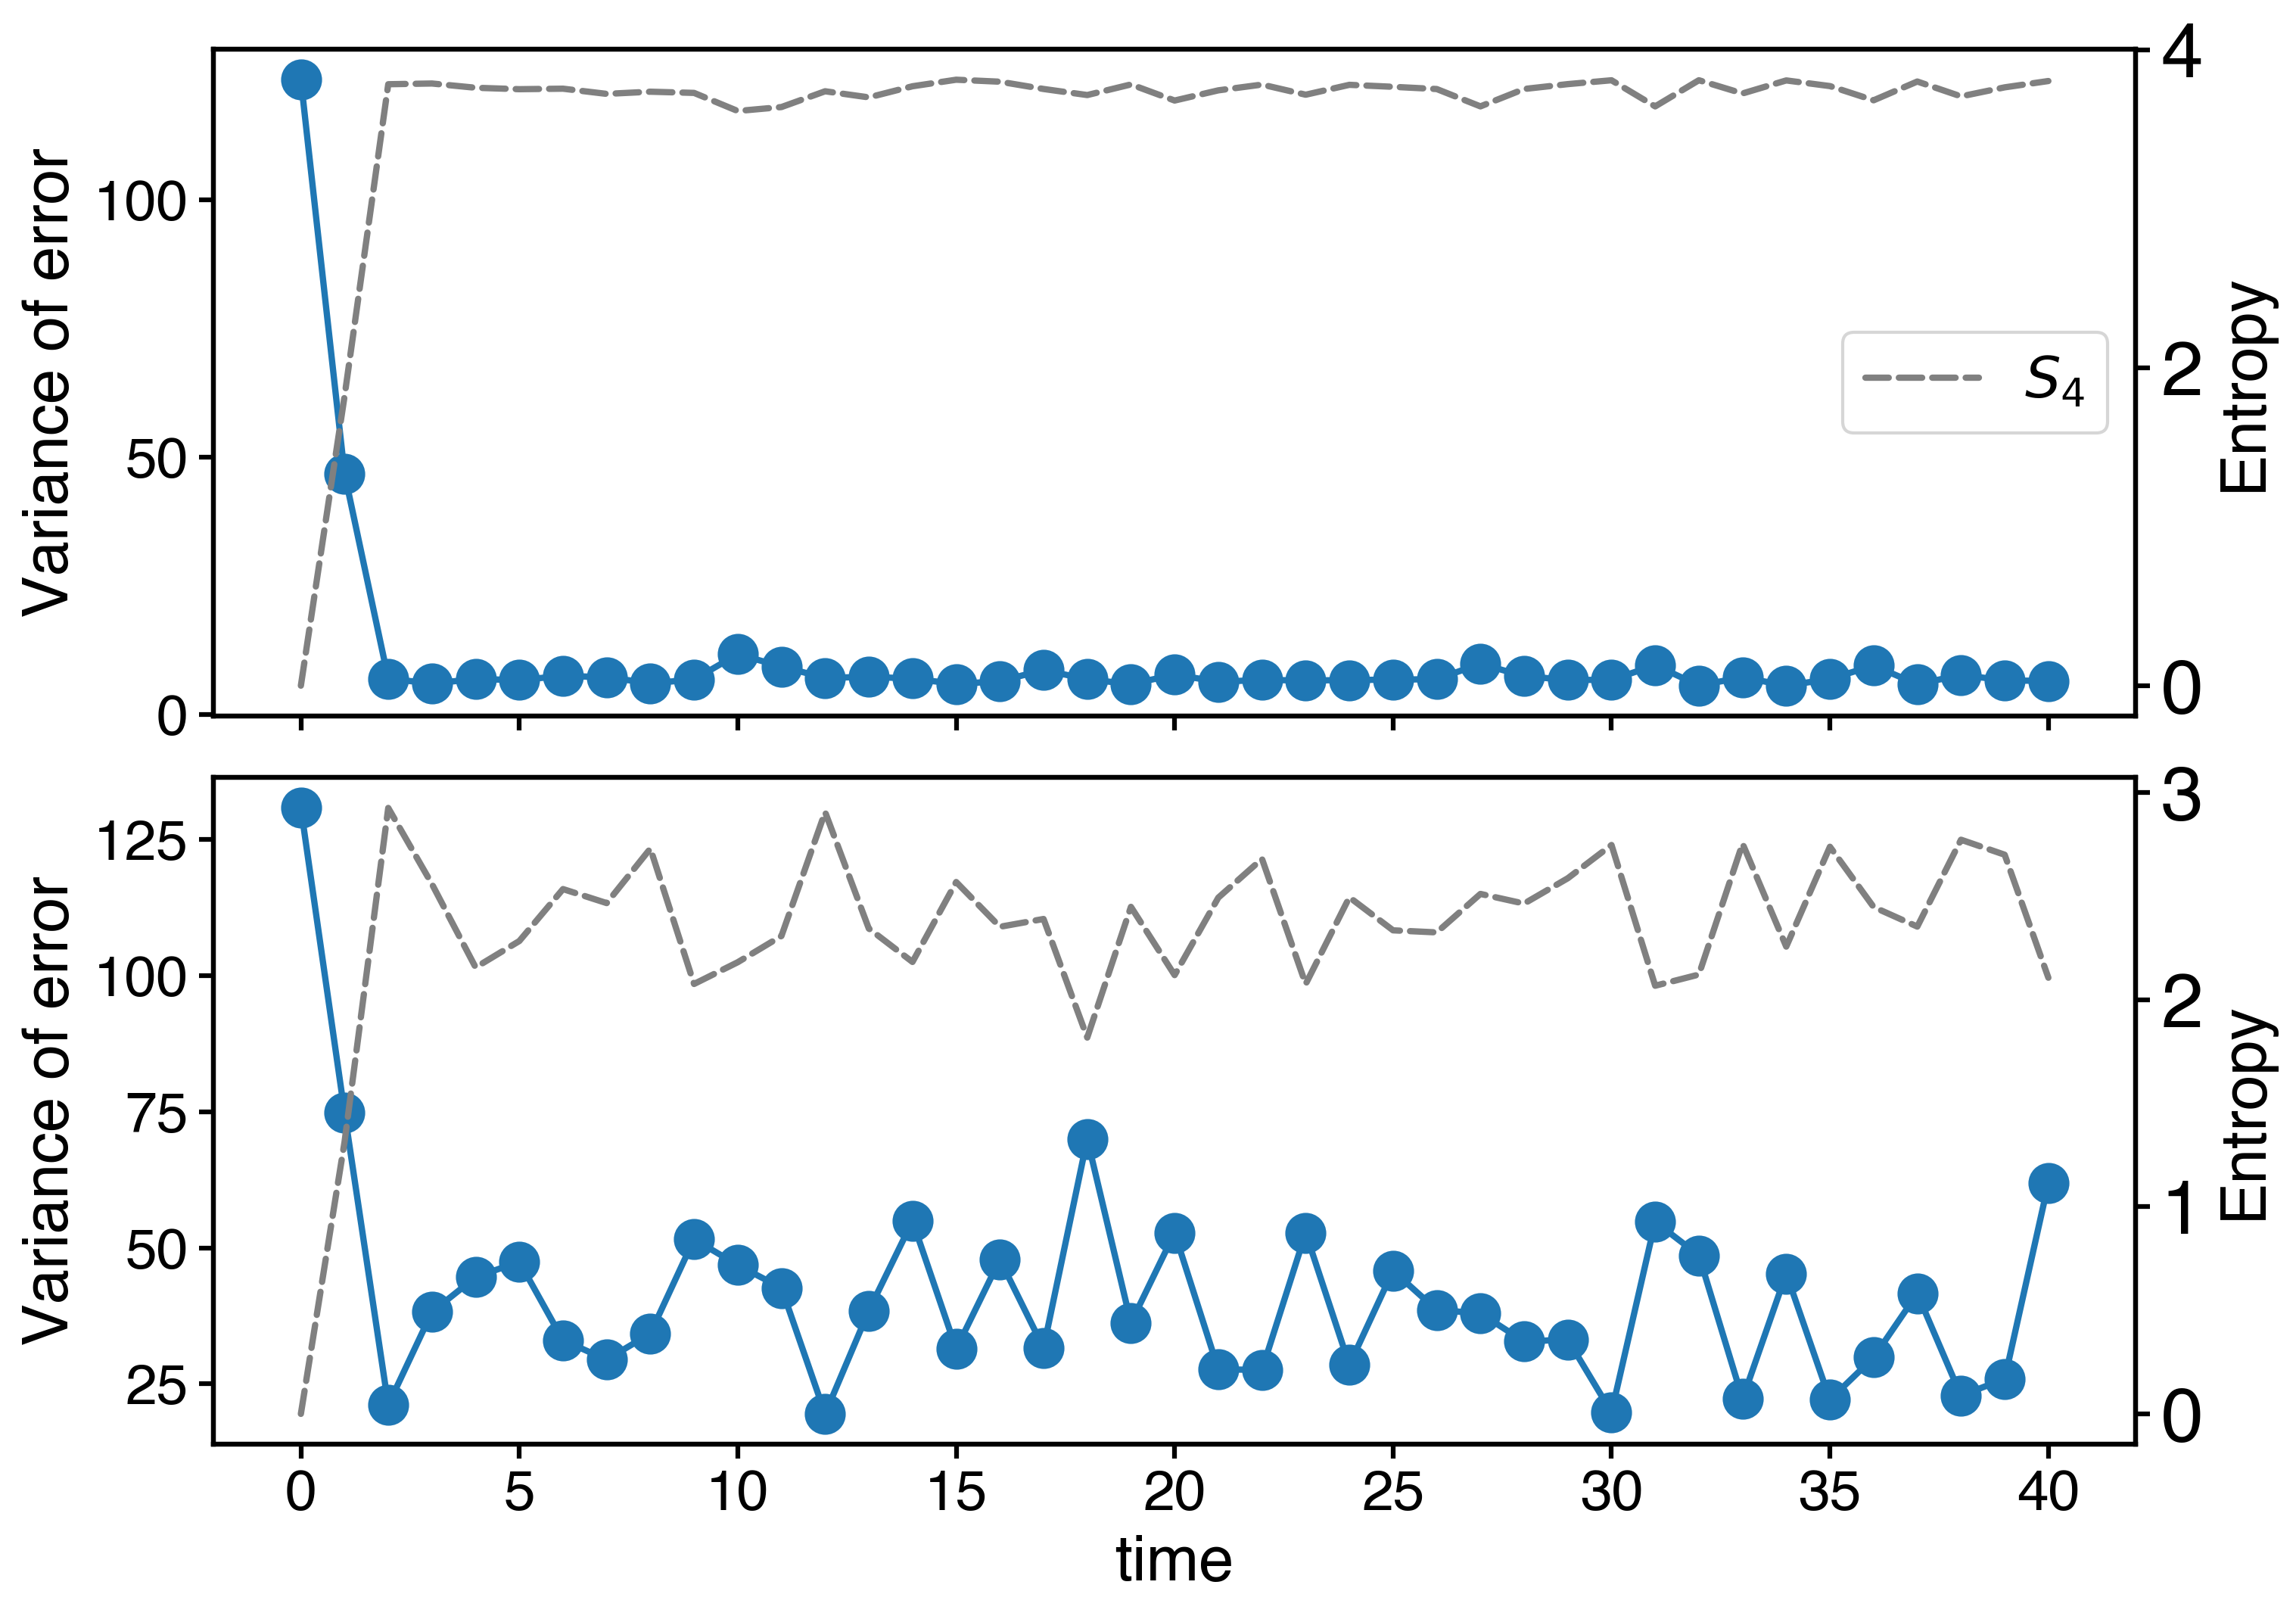

In [5]:
#plot the variance of the errors for typical and atypical states
fig, (ax2_up, ax2_down) = plt.subplots(2, 1, figsize=(10, 7), layout='constrained',sharex=True)
ax2_up.plot(np.arange(len(TypicalErrors)), Tyvariances, label='Typical', marker='o')
ax3_up=ax2_up.twinx()
ax3_up.plot(np.arange(len(TypicalErrors)), Tyentropies, label=r'$S_4$', linestyle='--', color='gray')
ax3_up.set_ylabel(r"Entropy", fontsize=label_size)
ax2_down.plot(np.arange(len(AtypicalErrors)), Atyvariances, label='Atypical', marker='o')
ax2_down.set_xlabel(r"time",fontsize=label_size)
ax2_up.set_ylabel(r"Variance of error",fontsize=label_size)
ax2_up.tick_params(axis='both', which='major', labelsize=label_size-2)
ax2_down.set_ylabel(r"Variance of error",fontsize=label_size)
ax2_down.tick_params(axis='both', which='major', labelsize=label_size-2)
ax3_down=ax2_down.twinx()
ax3_down.plot(np.arange(len(AtypicalErrors)), Atyentropies, label=r'$S_4$', linestyle='--', color='gray')
ax3_down.set_ylabel(r"Entropy", fontsize=label_size)
ax3_up.legend(loc='right')
plt.show()